In [1]:
import numpy as np

from pycbc.types import TimeSeries, load_frequencyseries
from pycbc.psd import interpolate

import ldc.io.hdf5 as hdfio

from matplotlib import pyplot as plt
plt.style.use('../paper.mplstyle')

/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
# This cell contains the information about inputs

input_data = '../datasets/LDC2_sangria_hm_training.h5'
output_format = '{channel}_sangria_hm_PSD.txt'
segment_duration = 1576800

In [3]:
# Load in the sangria dataset

tdi_ts, tdi_descr = hdfio.load_array(input_data, name="obs/tdi")
X = tdi_ts['X']
Y = tdi_ts['Y']
Z = tdi_ts['Z']

In [4]:
# Convert to AET timeseries
A = (Z - X)/np.sqrt(2)
E = (X - 2*Y + Z)/np.sqrt(6)
T = (X + Y + Z)/np.sqrt(3)

A_ts = TimeSeries(A, delta_t=5.)
E_ts = TimeSeries(E, delta_t=5.)
T_ts = TimeSeries(T, delta_t=5.)

In [5]:
# Calculate the PSDs

A_psd = A_ts.psd(segment_duration)
E_psd = E_ts.psd(segment_duration)
T_psd = T_ts.psd(segment_duration)

A_psd = interpolate(A_psd, A_ts.delta_f)
E_psd = interpolate(E_psd, E_ts.delta_f)
T_psd = interpolate(T_psd, T_ts.delta_f)

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


In [6]:
# Save to files for use in later analysis

# A_psd.save(output_format.format(channel='A'))
# E_psd.save(output_format.format(channel='E'))
# T_psd.save(output_format.format(channel='T'))

In [12]:
# We also want to plot the models that we used in the premerger paper
ae_model = load_frequencyseries('model_AE_TDI1_optimistic.txt')
t_model = load_frequencyseries('model_T_TDI1_optimistic.txt')


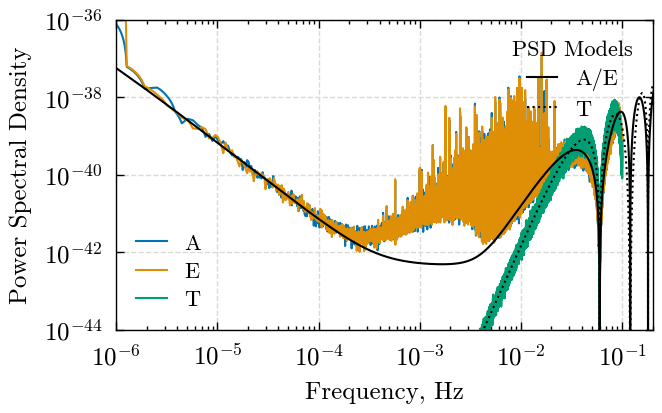

In [ ]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1)
ax.loglog(A_psd.sample_frequencies, A_psd, c=cycle[0], label='A')
ax.loglog(E_psd.sample_frequencies, E_psd, c=cycle[1], label='E')
ax.loglog(T_psd.sample_frequencies, T_psd, c=cycle[2], label='T')
ax.loglog(ae_model.sample_frequencies, ae_model, c='k')
ax.loglog(t_model.sample_frequencies, t_model, c='k', linestyle=':')
ax.set_ylabel("Power Spectral Density")
ax.set_xlabel("Frequency, Hz")
leg1 = ax.legend(loc='lower left')
line2 = [
    ax.loglog([],[],c='k')[0],
    ax.loglog([],[],c='k', linestyle=':')[0]
]
labels2 = ['A/E', 'T']
ax.legend(line2, labels2, loc="upper right", title="PSD Models")
ax.add_artist(leg1)
ax.set_ylim([1e-44, 1e-36])
ax.set_xlim([1e-6, 1e-1])
ax.grid(zorder=-100)



Now lets remove the dip at 0.06 Hz, lets remove stuff between 0.04 and 0.09 Hz

In [9]:
keep = np.logical_or(A_psd.sample_frequencies < 0.04, A_psd.sample_frequencies > 0.09)

smoothed_freq = A_psd.sample_frequencies[keep]
A_psd_smoothed = A_psd[keep]
E_psd_smoothed = E_psd[keep]

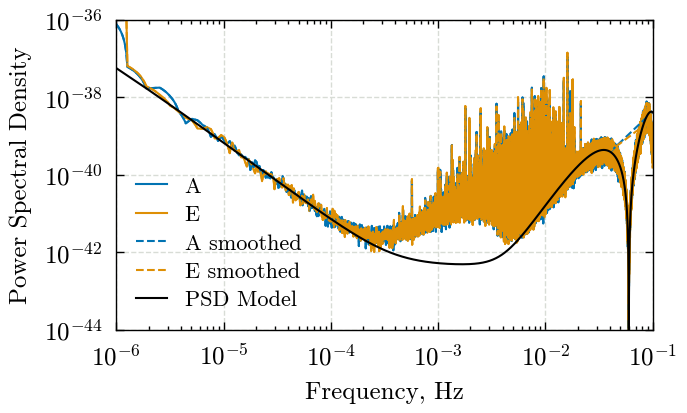

In [14]:
fig, ax = plt.subplots(1)
ax.loglog(A_psd.sample_frequencies, A_psd, c=cycle[0], label='A')
ax.loglog(E_psd.sample_frequencies, E_psd, c=cycle[1], label='E')
ax.loglog(smoothed_freq, A_psd_smoothed, label='A smoothed', linestyle='--', c=cycle[0])
ax.loglog(smoothed_freq, E_psd_smoothed, label='E smoothed', linestyle='--', c=cycle[1])
ax.loglog(ae_model.sample_frequencies, ae_model, c='k', label='PSD Model')
ax.set_ylabel("Power Spectral Density")
ax.set_xlabel("Frequency, Hz")
ax.legend(loc='lower left')
ax.set_ylim([1e-44, 1e-36])
ax.set_xlim([1e-6, 1e-1])
ax.grid(zorder=-100)
